# AADHAAR MOBILITY PULSE (AMP)

## STAGING & DATA PREPARATION

### Import Required Libraries

In [2]:
import pandas as pd
import numpy as np


### Load Cleaned Aadhaar Datasets

In [3]:
bio = pd.read_csv("api_data_aadhar_biometric_cleaned.csv")      # Dataset 1
demo = pd.read_csv("api_data_aadhar_demographic_cleaned.csv")  # Dataset 2
enrol = pd.read_csv("api_data_aadhar_enrolment_cleaned.csv")          # Dataset 3

### Date Standardization

In [4]:
for df in [enrol, bio, demo]:
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)


### Aggregation at Pincode Level

In [5]:
enrol_agg = enrol.groupby(
    ['date','state','district','pincode'], as_index=False
).sum()

bio_agg = bio.groupby(
    ['date','state','district','pincode'], as_index=False
).sum()

demo_agg = demo.groupby(
    ['date','state','district','pincode'], as_index=False
).sum()


In [6]:
df = enrol_agg.merge(
    bio_agg, on=['date','state','district','pincode'], how='outer'
).merge(
    demo_agg, on=['date','state','district','pincode'], how='outer'
)

df.fillna(0, inplace=True)


## FEATURE ENGINEERING FOR MIGRATION SIGNAL

### Core Transaction Metrics

In [7]:
# Total enrolments
df['total_enrolments'] = (
    df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
)

# Total biometric updates
df['total_bio_updates'] = (
    df['bio_age_5_17'] + df['bio_age_17_']
)

# Total demographic updates
df['total_demo_updates'] = (
    df['demo_age_5_17'] + df['demo_age_17_']
)

# Total updates
df['total_updates'] = df['total_bio_updates'] + df['total_demo_updates']

# Total Aadhaar transactions
df['total_transactions'] = df['total_updates'] + df['total_enrolments']


In [8]:
df['adult_updates'] = df['bio_age_17_'] + df['demo_age_17_']


## Migration Signal Components

### Adult Update Ratio

In [9]:
df['adult_update_ratio'] = np.where(
    df['total_updates'] > 0,
    df['adult_updates'] / df['total_updates'],
    0
)


### Update Intensity

In [10]:
df['update_intensity'] = np.where(
    df['total_transactions'] > 0,
    df['total_updates'] / df['total_transactions'],
    0
)


### Transaction Velocity

In [11]:
df.sort_values(['state','district','pincode','date'], inplace=True)

df['rolling_avg_txn'] = df.groupby(
    ['state','district','pincode']
)['total_transactions'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

df['velocity'] = np.where(
    df['rolling_avg_txn'] > 0,
    df['total_transactions'] / df['rolling_avg_txn'],
    1
)


## AMP SCORE COMPUTATION

### Raw AMP Score

In [12]:
df['amp_raw'] = (
    df['adult_update_ratio'] *
    df['update_intensity'] *
    df['velocity']
)


### Normalized AMP Score

In [13]:
min_val = df['amp_raw'].min()
max_val = df['amp_raw'].max()

df['amp_score'] = (df['amp_raw'] - min_val) / (max_val - min_val)


### MIGRATION INTERPRETATION FRAMEWORK

In [14]:
def amp_insight(score):
    if score <= 0.10:
        return "Stable population – routine Aadhaar activity"
    elif score <= 0.30:
        return "Minor population movement"
    elif score <= 0.60:
        return "Moderate temporary migration pressure"
    elif score <= 0.85:
        return "High migration / workforce movement"
    else:
        return "Very high migration surge – seasonal or economic shift"

df['human_insight'] = df['amp_score'].apply(amp_insight)


### SAVE FINAL OUTPUT DATASET

In [15]:
final_output = df[
    ['date','state','district','pincode','amp_score','human_insight']
]

final_output.to_csv(
    "aadhaar_migration_pulse_with_insight1.csv",
    index=False
)


## VISUAL ANALYTICS

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("aadhaar_migration_pulse_with_insight1.csv")

df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M").astype(str)


FileNotFoundError: [Errno 2] No such file or directory: 'aadhaar_migration_pulse_with_insight1.csv'

In [ ]:
state_monthly_avg = (
    df.groupby(["state", "month"])["amp_score"]
      .mean()
      .reset_index()
)

latest_month = state_monthly_avg["month"].max()

latest_state_amp = (
    state_monthly_avg[state_monthly_avg["month"] == latest_month]
    .sort_values("amp_score", ascending=False)
    .head(5)   
)




NameError: name 'df' is not defined

In [5]:
state_month_change = (
    state_monthly_avg
    .sort_values(["state", "month"])
)

state_month_change["mom_change"] = (
    state_month_change.groupby("state")["amp_score"].diff()
)
state_name_map = {
    "Dadra And Nagar Haveli And Daman And Diu": "Daman and Diu",
    
}
latest_change = (
    state_month_change[state_month_change["month"] == latest_month]
    .sort_values("mom_change", ascending=False)
    .dropna()
    .head(5)
)

latest_change["state_display"] = (
    latest_change["state"].replace(state_name_map)
)
plt.figure()
plt.bar(latest_change["state_display"], latest_change["mom_change"])
plt.axhline(0)
plt.title(f"Month-on-Month AMP Change – {latest_month}")
plt.xlabel("State")
plt.ylabel("AMP Change")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'state_monthly_avg' is not defined

### STATE-WISE MONTHLY TREND ANALYSIS

In [3]:

top_states = (
    state_monthly_avg.groupby("state")["amp_score"]
    .mean()
    .sort_values(ascending=False)
    .head(3)
    .index
)

state_monthly_top = state_monthly_avg[
    state_monthly_avg["state"].isin(top_states)
]

plt.figure()
for state in top_states:
    temp = state_monthly_top[state_monthly_top["state"] == state]
    plt.plot(temp["month"], temp["amp_score"], label=state)

plt.title("Monthly Aadhaar Migration Pulse Trend (Selected States)")
plt.xlabel("Month")
plt.ylabel("Average AMP Score")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'state_monthly_avg' is not defined

### DISTRICT MONTHLY RANKING

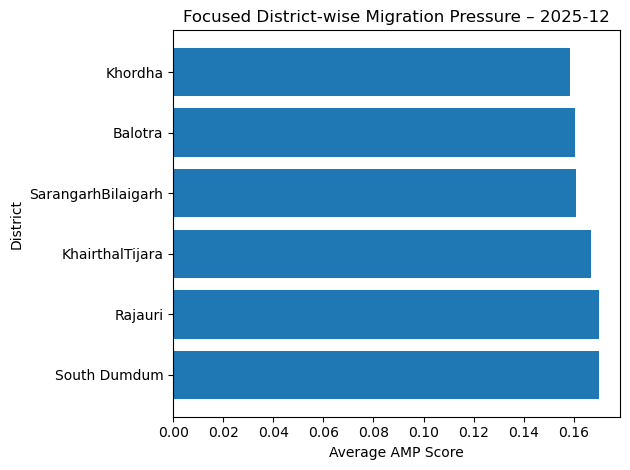

In [20]:
district_monthly_avg = (
    df.groupby(["state", "district", "month"])["amp_score"]
      .mean()
      .reset_index()
)

latest_district_amp = (
    district_monthly_avg[district_monthly_avg["month"] == latest_month]
    .sort_values("amp_score", ascending=False)
    .head(6)   # ONLY 6 DISTRICTS
)

plt.figure()
plt.barh(
    latest_district_amp["district"],
    latest_district_amp["amp_score"]
)
plt.title(f"Focused District-wise Migration Pressure – {latest_month}")
plt.xlabel("Average AMP Score")
plt.ylabel("District")
plt.tight_layout()
plt.show()


### NATIONAL MIGRATION TREND

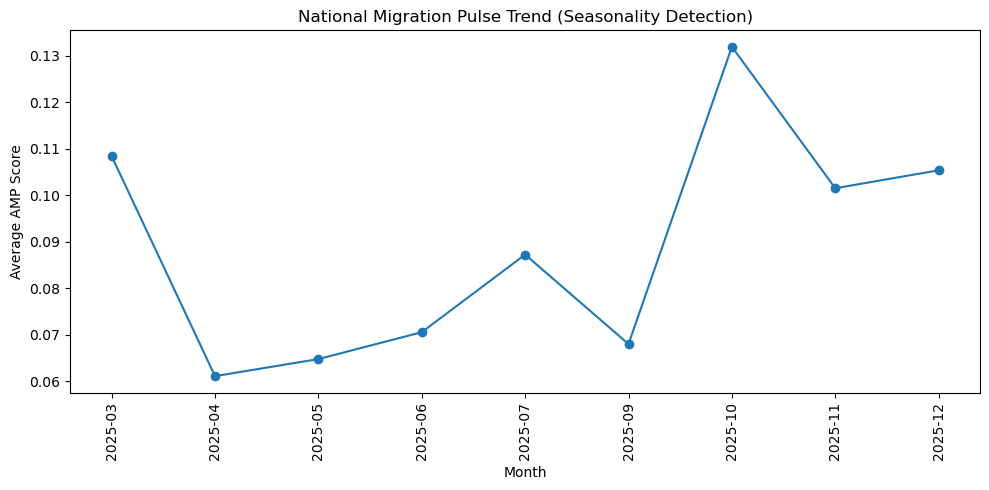

In [31]:
national_month_amp = (
    df.groupby('month')['amp_score']
      .mean()
      .reset_index()
)

plt.figure(figsize=(10,5))
plt.plot(
    national_month_amp['month'],
    national_month_amp['amp_score'],
    marker='o'
)

plt.title("National Migration Pulse Trend (Seasonality Detection)")
plt.xlabel("Month")
plt.ylabel("Average AMP Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


###  DISTRICT HEATMAP (SEASONALITY VIEW)

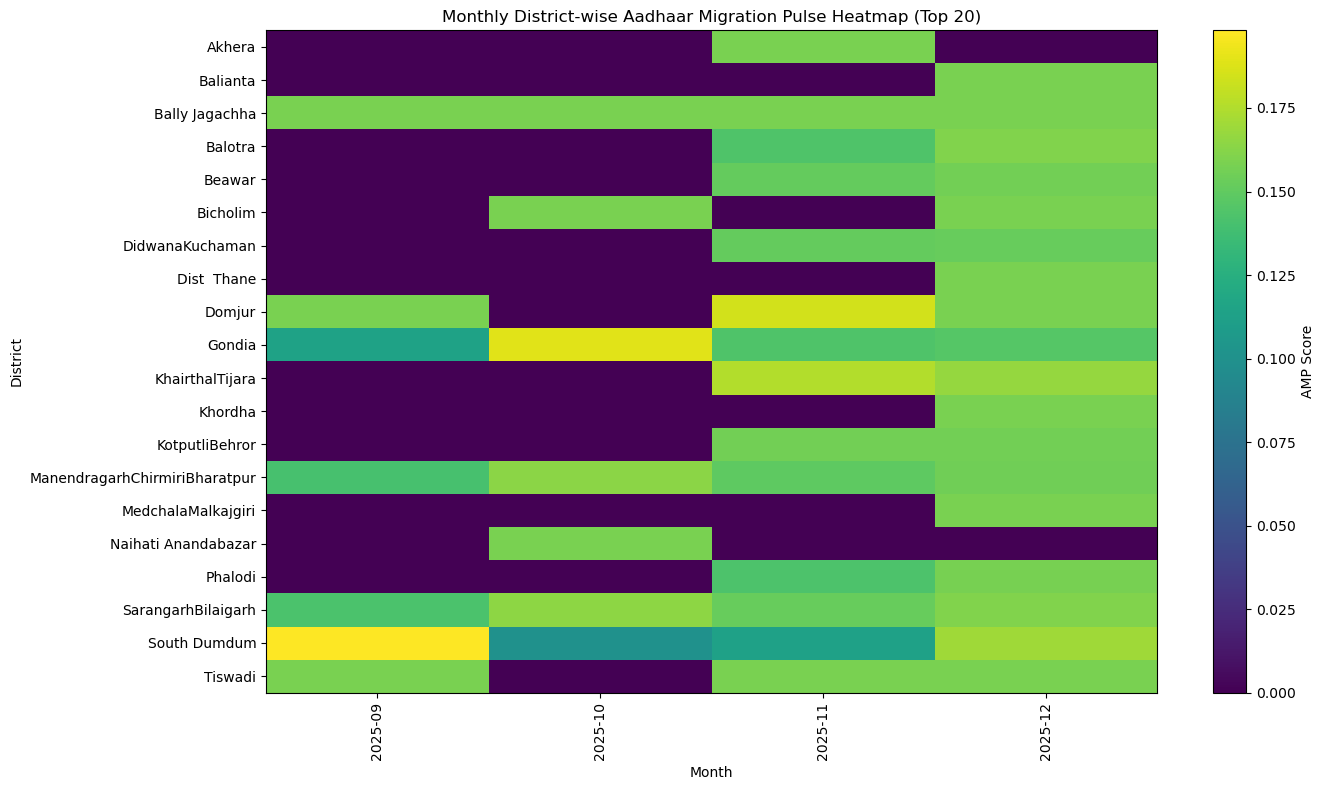

In [30]:
top_districts = (
    df.groupby('district')['amp_score']
      .mean()
      .sort_values(ascending=False)
      .head(20)
      .index
)

district_month_amp = (
    df[df['district'].isin(top_districts)]
    .groupby(['district','month'])['amp_score']
    .mean()
    .unstack(fill_value=0)
)

plt.figure(figsize=(14,8))
plt.imshow(district_month_amp, aspect='auto')
plt.colorbar(label="AMP Score")

plt.yticks(
    range(len(district_month_amp.index)),
    district_month_amp.index
)
plt.xticks(
    range(len(district_month_amp.columns)),
    district_month_amp.columns,
    rotation=90
)

plt.title("Monthly District-wise Aadhaar Migration Pulse Heatmap (Top 20)")
plt.xlabel("Month")
plt.ylabel("District")
plt.tight_layout()
plt.show()


## GEO-SPATIAL AMP VISUALIZATION

### PREPARE STATE & DISTRICT AMP AVERAGES

In [3]:
import geopandas as gpd
df = pd.read_csv("aadhaar_migration_pulse_with_insight1.csv")

state_amp = (
    df.groupby("state")["amp_score"]
      .mean()
      .reset_index()
)
district_amp = (
    df.groupby(["state", "district"])["amp_score"]
      .mean()
      .reset_index()
)


### LOAD SHAPEFILES

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load shapefiles
states_gdf = gpd.read_file("States\Admin2.shp")
districts_gdf = gpd.read_file("Districts\Census_2011\\2011_Dist.shp")


<>:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
<>:6: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
<>:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
<>:6: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
C:\Users\omyad\AppData\Local\Temp\ipykernel_10784\98269707.py:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
  states_gdf = gpd.read_file("States\Admin2.shp")
C:\Users\omyad\AppData\Local\Temp\ipykernel_10784\98269707.py:6: SyntaxWarning: "\C" is an invalid escape sequence. Such seque

### MERGE AMP WITH GEO DATA

In [7]:
states_amp_map = states_gdf.merge(
    state_amp,
    left_on="ST_NM",
    right_on="state",
    how="left"
)
states_amp_map["amp_score"] = states_amp_map["amp_score"].fillna(0)


In [8]:
districts_amp_map = districts_gdf.merge(
    district_amp,
    left_on=["ST_NM", "DISTRICT"],
    right_on=["state", "district"],
    how="left"
)
districts_amp_map["amp_score"] = districts_amp_map["amp_score"].fillna(0)


### STATE-WISE AMP MAP

<Figure size 1200x1200 with 0 Axes>

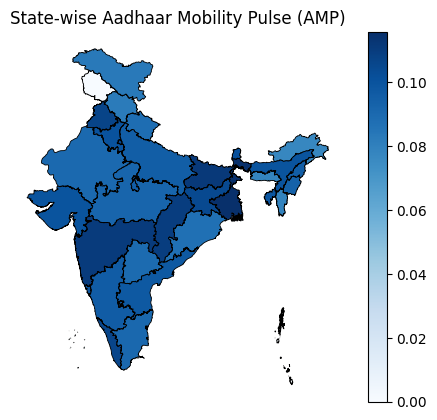

In [9]:
plt.figure(figsize=(12, 12))
states_amp_map.plot(
    column="amp_score",
    cmap="Blues",
    linewidth=0.6,
    edgecolor="black",
    legend=True
)

plt.title("State-wise Aadhaar Mobility Pulse (AMP)")
plt.axis("off")
plt.show()


### DISTRICT-WISE AMP MAP

<Figure size 1400x1400 with 0 Axes>

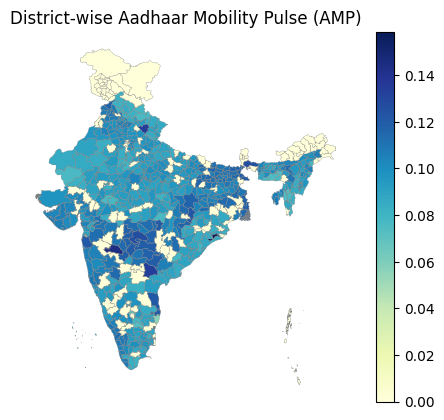

In [10]:
plt.figure(figsize=(14, 14))
districts_amp_map.plot(
    column="amp_score",
    cmap="YlGnBu",
    linewidth=0.2,
    edgecolor="grey",
    legend=True
)

plt.title("District-wise Aadhaar Mobility Pulse (AMP)")
plt.axis("off")
plt.show()
